In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.0'

## 1. Data (preparing and loading)

I want to stress that "data" in machine learning can be almost anything you can imagine. A table of numbers (like a big Excel spreadsheet), images of any kind, videos (YouTube has lots of data!), audio files like songs or podcasts, protein structures, text and more.

![machine learning is a game of two parts: 1. turn your data into a representative set of numbers and 2. build or pick a model to learn the representation as best as possible](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-machine-learning-a-game-of-two-parts.png)

Machine learning is a game of two parts: 
1. Turn your data, whatever it is, into numbers (a representation).
2. Pick or build a model to learn the representation as best as possible.

Sometimes one and two can be done at the same time.

But what if you don't have data?

Well, that's where we're at now.

No data.

But we can create some.

Let's create our data as a straight line.

We'll use [linear regression](https://en.wikipedia.org/wiki/Linear_regression) to create the data with known **parameters** (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using [**gradient descent**](https://en.wikipedia.org/wiki/Gradient_descent).


In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X),len(y)

(50, 50)

Beautiful! Now we're going to move towards building a model that can learn the relationship between `X` (**features**) and `y` (**labels**). 

### Split data into training and test sets 

We've got some data.

But before we build a model we need to split it up.

One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each split of the dataset serves a specific purpose:

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |

For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.

We can create them by splitting our `X` and `y` tensors.

> **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.


In [4]:
# Create train/test split
# Note:- It will use sequential 80 % data to train and remaining 20% data to test
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
#using sklearn
# Note:- It will use random 20 % data to test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Wonderful, we've got 40 samples for training (`X_train` & `y_train`) and 10 samples for testing (`X_test` & `y_test`).

The model we create is going to try and learn the relationship between `X_train` & `y_train` and then we will evaluate what it learns on `X_test` and `y_test`.

But right now our data is just numbers on a page.

Let's create a function to visualize it.

In [6]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
    plt.legend()  #or
    plt.legend(prop={"size": 14}); 

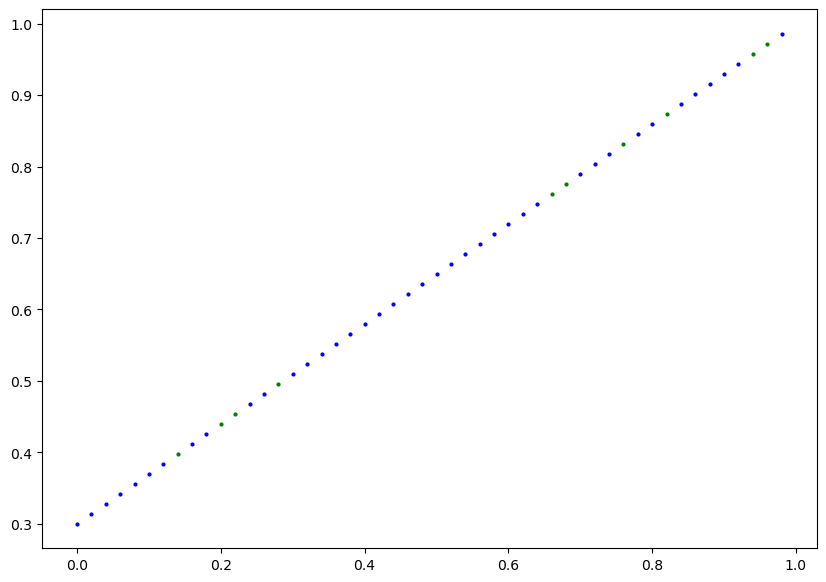

In [7]:
plot_predictions()

## 2. Build model

Now we've got some data, let's build a model to use the blue dots to predict the green dots.

We're going to jump right in.

We'll write the code first and then explain everything. 

Let's replicate a standard linear regression model using pure PyTorch.

In [8]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)